In [1]:
import pandas as pd

In [2]:
#Reading data

df_train = pd.read_csv('tweets_hate_speech_transformers/train_E6oV3lV.csv').set_index('id')

df_train.head(20)

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before the...
7,0,@user camping tomorrow @user @user @user @use...
8,0,the next school year is the year for exams.ð...
9,0,we won!!! love the land!!! #allin #cavs #champ...


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB


## label = 0 is non-hate speech tweet, and label=1 is hate speech tweet 

In [8]:
df_train.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)

,label,tweet
0,0,29720
1,1,2242


## Data is imbalanced, there is >90% of non-hate speech tweets

<AxesSubplot:xlabel='label', ylabel='count'>

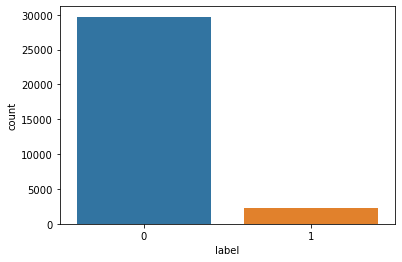

In [10]:
import seaborn as sns

sns.countplot(x='label', data=df_train)

In [11]:
label_0 = len(df_train[df_train['label']==0]) 
label_1 = len(df_train[df_train['label']==1])
perc_0 = label_0/(label_0+label_1)*100
perc_1 = label_1/(label_0+label_1)*100

print(f'There is {label_1} hate speech tweets, which represents {perc_1:.2f}%')
print(f'There is {label_0} non hate speech tweets, which represents {perc_0:.2f}%')

There is 2242 hate speech tweets, which represents 7.01%
There is 29720 non hate speech tweets, which represents 92.99%


## Graphical representation of most common words

(-0.5, 799.5, 399.5, -0.5)

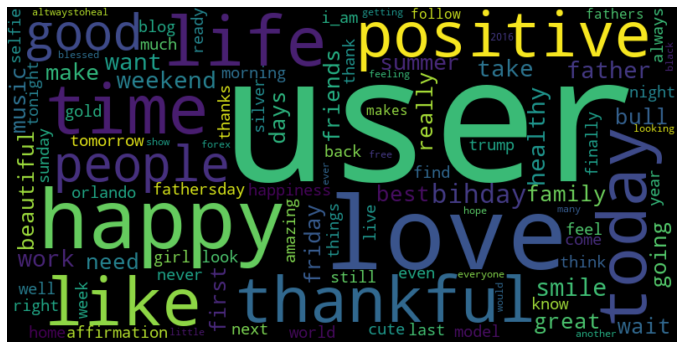

In [13]:
from nltk import sent_tokenize, word_tokenize, regexp_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def tokenize(text, pat='(?u)\\b\\w\\w+\\b', stop_words='english', min_len=2):
    if stop_words:
        stop = set(stopwords.words(stop_words))
    return [w
            for w in regexp_tokenize(text.casefold(), pat)
            if w not in stop and len(w) >= min_len]



words = tokenize(df_train['tweet'].str.cat(sep=' '), min_len=4)

fdist = FreqDist(words)

wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(fdist)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

## Cleaning the tweets

In [20]:
#Cleaning the tweets

import re, emoji
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from unicodedata import normalize

def cleaner(tweet):
    tweet = "".join(u for u in tweet if u not in ("?", ".", ",", ";", ":", "!", '"', "'", "¡", "¿"))
    tweet = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize( "NFD", tweet), 0, re.I)
    tweet = normalize( 'NFC', tweet) #Esta linea y la anterior transforma á -> a, é -> e ....
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split()) #Removes the @user
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r"[^a-zA-Z]", " ", str(tweet).lower())
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    
    # Tokenize text
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    token = tokenizer.tokenize(tweet)
    
    # Remove stop words
    stop = stopwords.words("english")
    words = [t for t in token if t not in stop]
    
    # Lemmatization
    lem = " ".join(temp for temp in [WordNetLemmatizer().lemmatize(w) for w in words])
    
    return lem

df_train['tweet'] = df_train['tweet'].map(lambda x: cleaner(x))
df_train['tweet'].head(20)

id
1     father dysfunctional selfish drag kid dysfunct...
2     thanks lyft credit cant use cause dont offer w...
3                                        bihday majesty
4                           model love u take u time ur
5                         factsguide society motivation
6     huge fan fare big talking leave chaos pay disp...
7                               camping tomorrow dannya
8     next school year year exam cant think school e...
9     love land allin cavs champion cleveland clevel...
10                                        welcome im gr
11    ireland consumer price index mom climbed previ...
12    selfish orlando standwithorlando pulseshooting...
13                   get see daddy today day gettingfed
14    cnn call michigan middle school build wall cha...
15    comment australia opkillingbay seashepherd hel...
16              ouchjunior angry got junior yugyoem omg
17                     thankful paner thankful positive
18                                        ret

## Most common words

In [21]:
from collections import Counter

df_train['list'] = df_train['tweet'].apply(lambda x:str(x).split()) #Words in each row
top = Counter([item for sublist in df_train['list'] for item in sublist]) 
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,day,2859
1,love,2802
2,u,1728
3,happy,1692
4,amp,1627
5,time,1244
6,life,1225
7,like,1200
8,im,1146
9,today,1085


## Most positive common words

In [22]:
pos = df_train[df_train['label']==0]

pos['list'] = pos['tweet'].apply(lambda x:str(x).split()) #Words in each row
top = Counter([item for sublist in pos['list'] for item in sublist]) 
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Positive common_words','count']
temp.style.background_gradient(cmap='Greens')

C:\Users\USER\AppData\Local\Temp\ipykernel_12800\2253371834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['list'] = pos['tweet'].apply(lambda x:str(x).split()) #Words in each row


,Common_words,count
0,day,2844
1,love,2773
2,happy,1680
3,u,1634
4,amp,1356
5,time,1214
6,life,1211
7,im,1101
8,today,1069
9,like,1062


## Most negative (hate speech) common words

In [24]:
neg = df_train[df_train['label']==1]

neg['list'] = neg['tweet'].apply(lambda x:str(x).split()) #Words in each row
top = Counter([item for sublist in neg['list'] for item in sublist]) 
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Reds')

C:\Users\USER\AppData\Local\Temp\ipykernel_12800\2857067761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg['list'] = neg['tweet'].apply(lambda x:str(x).split()) #Words in each row


,Common_words,count
0,amp,271
1,trump,211
2,white,155
3,black,149
4,libtard,149
5,like,138
6,woman,121
7,racist,112
8,politics,96
9,u,94
